# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

Из курса математического анализа мы знаем:
$$
df=\langle \nabla_{x}f,dx \rangle 
$$
Найдём дифференциал:
$$
dL(w)=-yd(\log \sigma(w^{T}x))-(1-y)d\log(1-\sigma(w^{T}x))+\gamma d \lVert w \rVert _{1}+\beta d\lVert w \rVert ^{2}_{2}
$$
$$
\begin{align}
dL(w)=&\frac{-y}{\sigma(w^{T}x)}\cdot \sigma(w^{T}x)(1 - \sigma(w^{T}x))\cdot d(w)^{T}x +\\[5pt]
&\frac{1-y}{1-\sigma(w^{T}x)}\cdot \sigma(w^{T}x)(1-\sigma(w^{T}x))\cdot d(w)^{T}x+\\[5pt]
&\gamma \cdot \langle \mathrm{sign}(w),dw \rangle + \\[5pt]
&2\beta \cdot \langle w,dw \rangle  
\end{align}
$$
$$
\begin{align}
dL(w)=&(\frac{-y}{\sigma(w^{T}x)}+\frac{1-y}{1-\sigma(w^{T}x)}) 
\cdot \sigma(w^{T}x)(1 - \sigma(w^{T}x))\cdot d(w)^{T}x +\\[5pt]
&\gamma \cdot \langle \mathrm{sign}(w),dw \rangle + \\[5pt]
&2\beta \cdot \langle w,dw \rangle  
\end{align}
$$
$$
\begin{align}
dL(w)=& \frac{\sigma(w^{T}x)-y}{\sigma(w^{T}x)(1-\sigma(w^{T}x))}
\cdot \sigma(w^{T}x)(1 - \sigma(w^{T}x))\cdot d(w)^{T}x +\\[5pt]
&\gamma \cdot \langle \mathrm{sign}(w),dw \rangle + \\[5pt]
&2\beta \cdot \langle w,dw \rangle  
\end{align}
$$
$$
\begin{align}
dL(w)&= (\sigma(w^{T}x)-y)\langle dw,x \rangle+ \gamma \cdot \langle \mathrm{sign}(w),dw \rangle + 2\beta \cdot \langle w,dw \rangle  \\
&= \langle (\sigma(w^{T}x)-y)x, dw\rangle+ \langle \gamma \cdot\mathrm{sign}(w),dw \rangle + \langle 2\beta w,dw \rangle  \\
&=\langle (\sigma(w^{T}x)-y)x + \gamma \cdot\mathrm{sign}(w)+2\beta w, dw \rangle 
\end{align}
$$
Таким образом получаем, что
$$
\nabla_{w}L(w)=(\sigma(w^{T}x)-y)x+\gamma \cdot \mathrm{sign}(w)+2\beta w
$$


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def loss(X, y, w, gamma=1.0, beta=1.0) -> float:
    

    pred = sigmoid(X @ w)
    return (
        -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))
        + gamma * np.linalg.norm(w, ord=1)
        + beta * np.linalg.norm(w, ord=2) ** 2
    )


#### 3. [0.25 points] Implement the gradient (as a function)

In [4]:
def get_grad(X, y, w, gamma=1., beta=1.) -> np.ndarray:
    pred = sigmoid(X @ w)
    grad_w = (pred - y) @ X + 2 * beta * w + gamma * np.sign(w)
    return grad_w

#### Check yourself

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [44]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import hstack

In [59]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.losses = []
        # you may additional properties if you wish

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.w = np.random.normal(size=X.shape[1] + 1)
        X = hstack([np.ones((X.shape[0], 1)), X])

        for i in range(self.max_iter):
            self.losses.append(loss(X, y, self.w, self.gamma, self.beta))
            grad = get_grad(X, y, self.w, self.gamma, self.beta)
            self.w -= self.lr * grad
            if np.linalg.norm(grad) < self.tolerance:
                break

        return self

    def predict(self, X):
        X = hstack([np.ones((X.shape[0], 1)), X])
        predict = np.round(sigmoid(X @ self.w))
        return predict.astype(int)

    def predict_proba(self, X):
        X = hstack([np.ones((X.shape[0], 1)), X])
        probas = sigmoid(X @ self.w)
        return np.vstack([1-probas, probas]).T

In [8]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [9]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

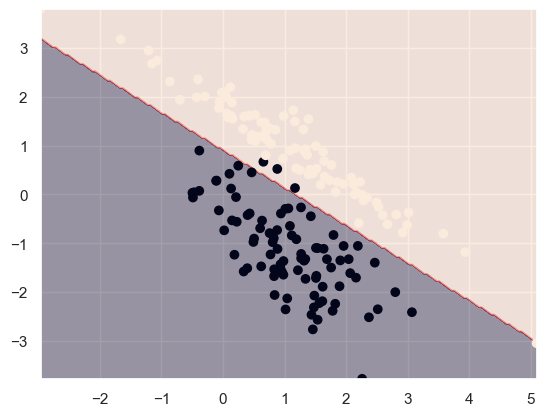

In [10]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0.5, 1.0, 'Loss function over iterations')

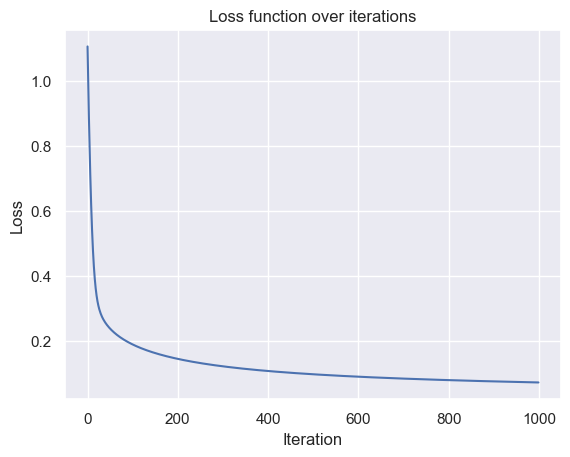

In [11]:
plt.plot(model.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss function over iterations')

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)

# I've split data into train and test sets,
# however this makes test samples linearly separable, thus I'm using the whole
# dataset for training and testing like in the example above 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_decision_scores = model.decision_function(X_test)
    plot_decision_boundary(model, X_test, y_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_decision_scores),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
    }

{'accuracy': 0.9777777777777777,
 'roc_auc': 0.9993827160493827,
 'f1': 0.978021978021978,
 'precision': 0.967391304347826,
 'recall': 0.9888888888888889}

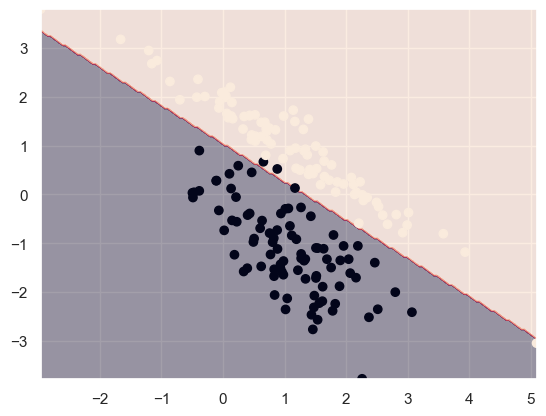

In [14]:
evaluate_model(SVC(kernel='linear'), X, y, X, y)

{'accuracy': 0.9666666666666667,
 'roc_auc': 0.9964197530864197,
 'f1': 0.967032967032967,
 'precision': 0.9565217391304348,
 'recall': 0.9777777777777777}

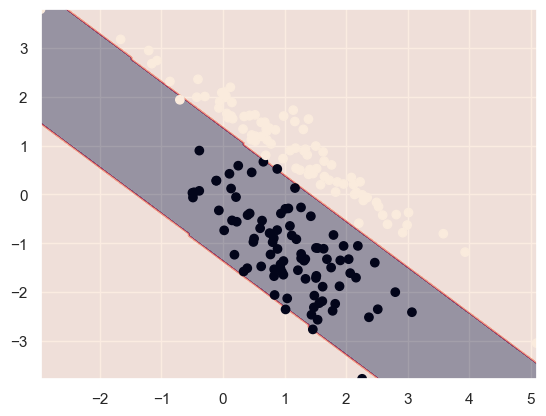

In [15]:
evaluate_model(SVC(kernel='poly', degree=2), X, y, X, y)

{'accuracy': 0.9944444444444445,
 'roc_auc': 1.0,
 'f1': 0.994413407821229,
 'precision': 1.0,
 'recall': 0.9888888888888889}

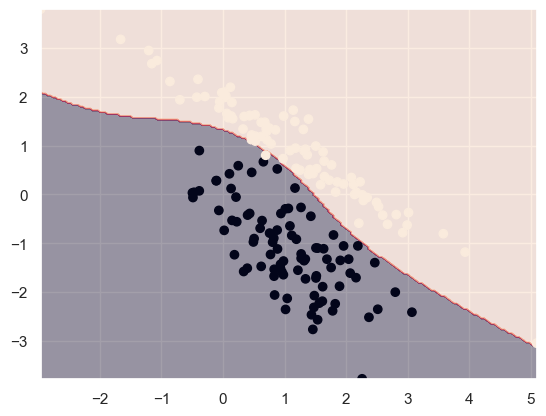

In [16]:
evaluate_model(SVC(kernel='poly', degree=3), X, y, X, y)

{'accuracy': 0.9833333333333333,
 'roc_auc': 0.999753086419753,
 'f1': 0.9836065573770492,
 'precision': 0.967741935483871,
 'recall': 1.0}

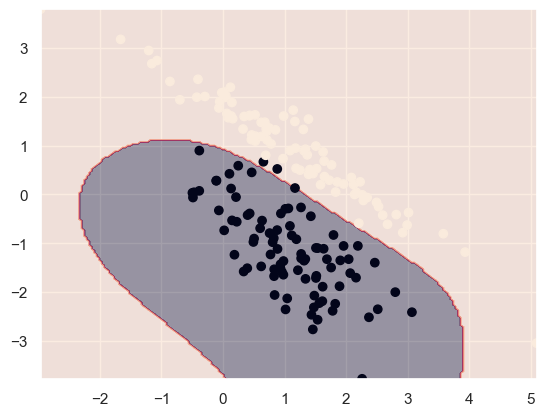

In [17]:
evaluate_model(SVC(kernel='rbf'), X, y, X, y)

{'accuracy': 0.8333333333333334,
 'roc_auc': 0.8764197530864197,
 'f1': 0.8255813953488372,
 'precision': 0.8658536585365854,
 'recall': 0.7888888888888889}

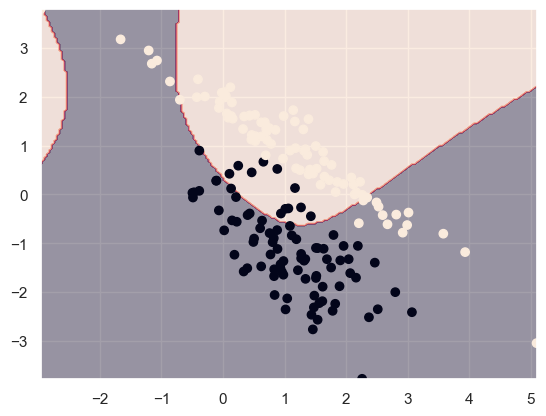

In [18]:
evaluate_model(SVC(kernel='sigmoid'), X, y, X, y)

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [19]:
import os
from nltk.tokenize import sent_tokenize
import pandas as pd
from tqdm import tqdm

data = []

for cls in tqdm(os.listdir("data/")):
    # print(cls)
    for file in os.listdir(f"data/{cls}"):
        # print(file)
        with open(f"data/{cls}/{file}") as f:
            for sentence in sent_tokenize(f.read()):
                if len(sentence) >= 15:
                    data.append({"sentence": sentence, "author": cls})

df = pd.DataFrame(data)

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


In [20]:
df.value_counts("author")

author
Dostoevsky    112370
Turgenev       25032
Gogol          23797
Chekhov        21923
Pushkin        10222
Lermontov       3042
Name: count, dtype: int64

In [21]:
proportions = {
    "Dostoevsky": 20000,
    "Turgenev": 15000,
    "Gogol": 11000,
    "Chekhov": 8000,
    "Pushkin": 5000,
    "Lermontov": 3000
}

np.random.seed(0)
df_sampled = pd.concat([
    df[df.author == author].sample(n=proportions[author])
    for author in proportions
])

df_sampled.head()

,sentence,author
106810,И ему вдруг стало ужасно досадно.,Dostoevsky
108877,Он злобно усмехнулся.,Dostoevsky
9679,– в злобном нетерпении и как бы властно крикну...,Dostoevsky
100119,"То есть, если я бы завтра и не уехал (кажется,...",Dostoevsky
74795,Я сама буду княгиня; меня и в Петербурге узнают.,Dostoevsky


In [22]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tqdm import tqdm

tqdm.pandas()

lemmatizer = WordNetLemmatizer()


def process_text(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.lower() not in stopwords.words("russian")]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isdigit()]
    tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens]

    return " ".join(tokens)


df_sampled["sentence"] = df_sampled.sentence.progress_apply(process_text)

df_sampled.head()

100%|██████████| 62000/62000 [00:54<00:00, 1147.07it/s]


,sentence,author
106810,стало ужасно досадно,Dostoevsky
108877,злобно усмехнулся,Dostoevsky
9679,– злобном нетерпении властно крикнул ставрогина,Dostoevsky
100119,завтра уехал кажется уеду наверно как-нибудь в...,Dostoevsky
74795,сама буду княгиня петербурге узнают,Dostoevsky


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer


authors = ["Pushkin", "Lermontov"]
binary_df = df_sampled[df_sampled["author"].isin(authors)]

print("Class distribution:")
print(binary_df["author"].value_counts())

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(binary_df.sentence)
y = (binary_df["author"] == authors[0]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42
)

Class distribution:
author
Pushkin      5000
Lermontov    3000
Name: count, dtype: int64


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
}

svm_grid = GridSearchCV(SVC(), param_grid, scoring="f1", cv=5)
svm_grid.fit(X_train, y_train)
print("\nBest SVM parameters:", svm_grid.best_params_)
svm_model = svm_grid.best_estimator_


Best SVM parameters: {'C': 10, 'kernel': 'rbf'}



SVM Results:


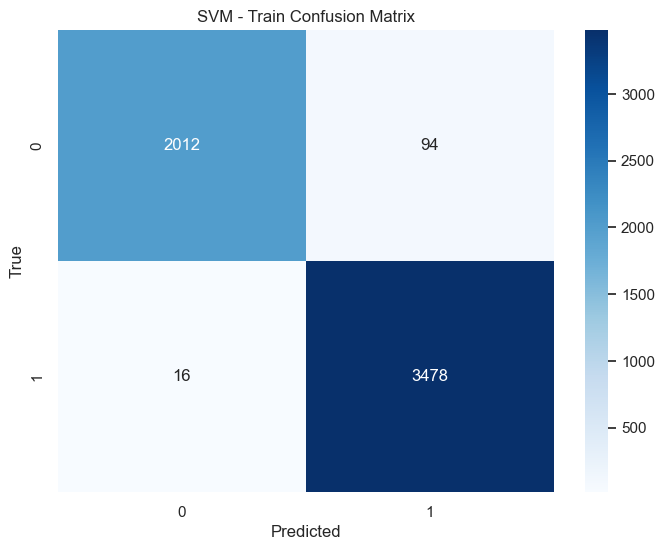

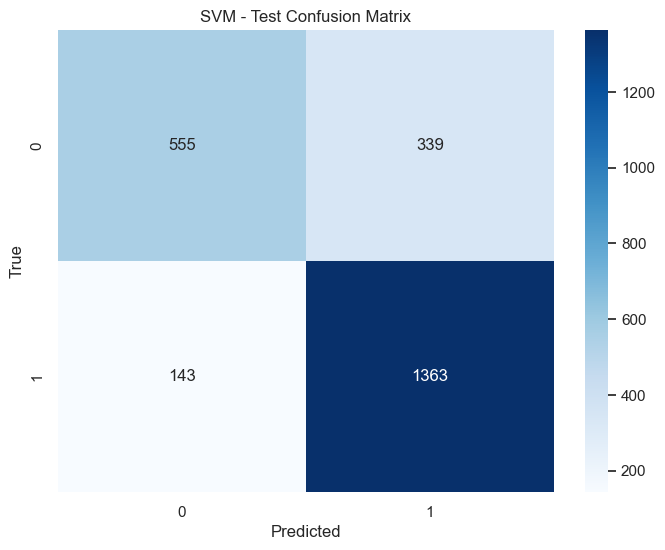


Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       894
           1       0.80      0.91      0.85      1506

    accuracy                           0.80      2400
   macro avg       0.80      0.76      0.77      2400
weighted avg       0.80      0.80      0.79      2400


Logistic Regression Results:


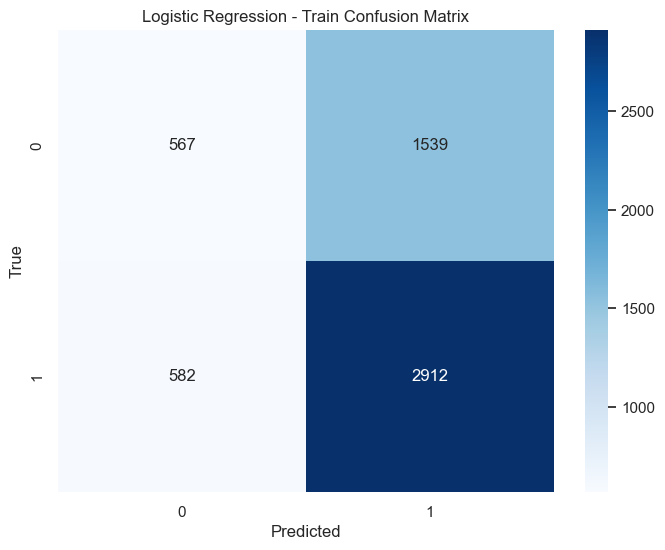

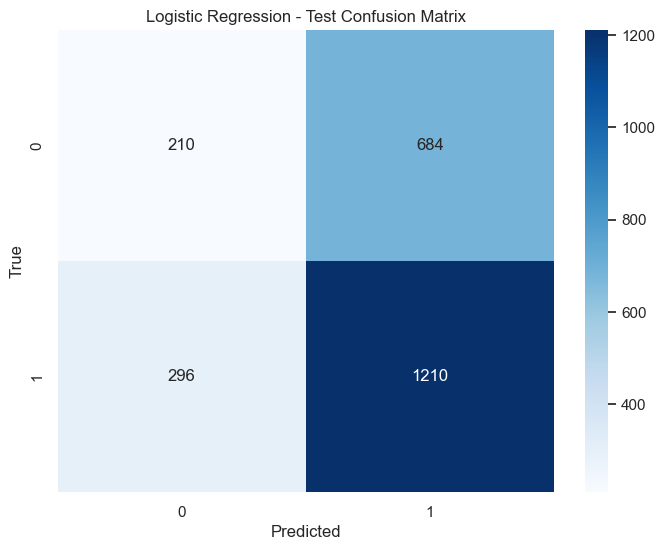


Test Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.23      0.30       894
           1       0.64      0.80      0.71      1506

    accuracy                           0.59      2400
   macro avg       0.53      0.52      0.51      2400
weighted avg       0.56      0.59      0.56      2400



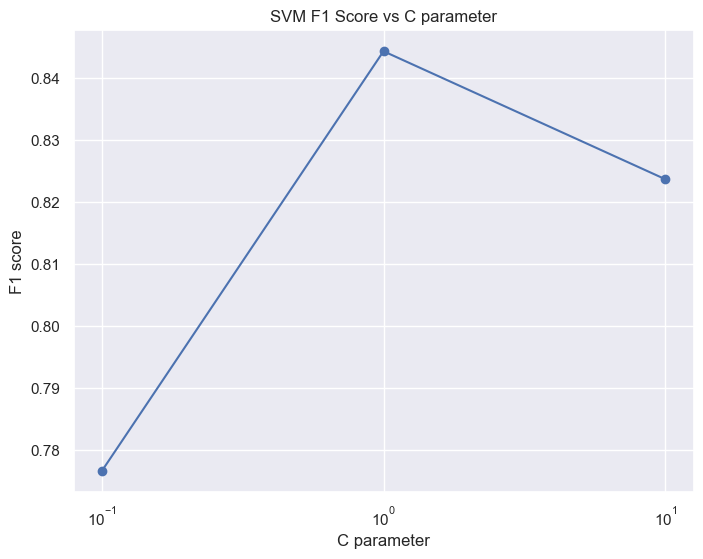

In [50]:
lr_model = Logit(max_iter=100)
lr_model.fit(X_train.toarray(), y_train)


def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


for name, model in [("SVM", svm_model), ("Logistic Regression", lr_model)]:
    print(f"\n{name} Results:")

    train_pred = model.predict(X_train)
    plot_confusion_matrix(
        y_train, train_pred, f"{name} - Train Confusion Matrix"
    )

    test_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, test_pred, f"{name} - Test Confusion Matrix")

    print("\nTest Classification Report:")
    print(classification_report(y_test, test_pred))


C_values = [0.1, 1, 10]
f1_scores = []

for c in C_values:
    svm = SVC(C=c, kernel="linear")
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    f1 = f1_score(y_test, pred)
    f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(C_values, f1_scores, marker="o")
plt.xscale("log")
plt.xlabel("C parameter")
plt.ylabel("F1 score")
plt.title("SVM F1 Score vs C parameter")
plt.grid(True)
plt.show()

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

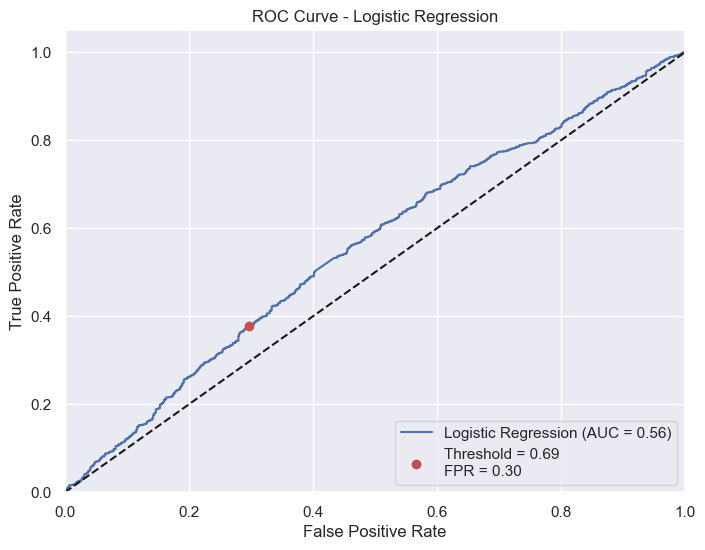

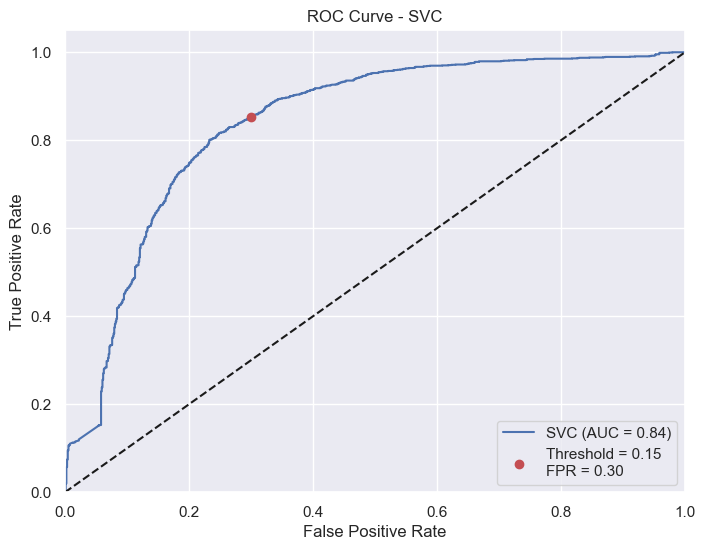

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_roc_with_thresholds(model, X_test, y_test, model_name):
    # Get model predictions probabilities
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:  # For SVC, use decision_function
        y_scores = model.decision_function(X_test)

    # Calculate ROC curve points and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Find threshold where FPR <= 0.3
    target_fpr = 0.3
    valid_idx = np.where(fpr <= target_fpr)[0][-1]

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    # Mark the point where FPR = 0.3
    plt.plot(
        fpr[valid_idx],
        tpr[valid_idx],
        "ro",
        label=f"Threshold = {thresholds[valid_idx]:.2f}\nFPR = {fpr[valid_idx]:.2f}",
    )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


plot_roc_with_thresholds(lr_model, X_test, y_test, "Logistic Regression")
plot_roc_with_thresholds(svm_model, X_test, y_test, "SVC")

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

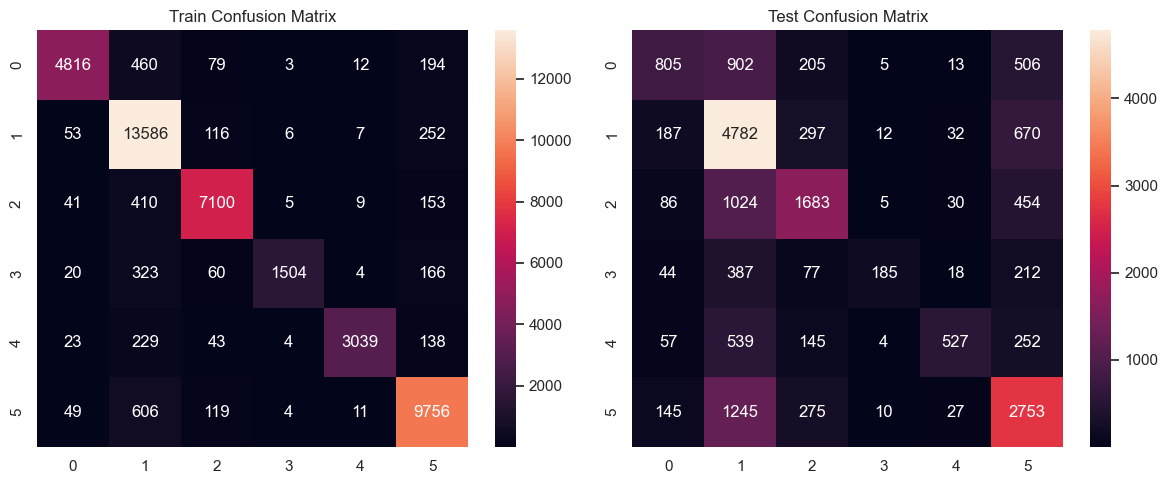


Classification Report (Test Set):
              precision    recall  f1-score   support

     Chekhov       0.61      0.33      0.43      2436
  Dostoevsky       0.54      0.80      0.64      5980
       Gogol       0.63      0.51      0.56      3282
   Lermontov       0.84      0.20      0.32       923
     Pushkin       0.81      0.35      0.49      1524
    Turgenev       0.57      0.62      0.59      4455

    accuracy                           0.58     18600
   macro avg       0.67      0.47      0.51     18600
weighted avg       0.61      0.58      0.56     18600



In [64]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

X = TfidfVectorizer().fit_transform(df_sampled.sentence)
y = df_sampled.author
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

param_grid = {
    "estimator__lr": [0.01, 0.001],
}

use_grid_search = False
if use_grid_search:
    ovo = OneVsOneClassifier(Logit())
    grid_search = GridSearchCV(ovo, param_grid, cv=5, scoring="f1_macro")
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
else:
    best_model = OneVsOneClassifier(RidgeClassifier()).fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt="d")
plt.title("Train Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

if use_grid_search:
    print("\nBest parameters:", grid_search.best_params_)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))